In [8]:
pip install tldextract

In [31]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
import re
import tldextract
from urllib.parse import urlparse
import logging
logging.getLogger('matplotlib.font_manager').setLevel(level=logging.CRITICAL)

from nltk.tokenize import word_tokenize
from wordcloud import WordCloud,STOPWORDS
from nltk.tokenize import RegexpTokenizer # regexp tokenizers use to split words from text
from nltk.stem.snowball import SnowballStemmer # stemmes words
import time # calculate time

#Garbage
import gc

#Warnings
import warnings
warnings.filterwarnings("ignore")

#SKLearn Libraries

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from sklearn.ensemble import StackingClassifier
from scipy.sparse import hstack
import scipy.sparse

#WordCloud Generator
from wordcloud import WordCloud,STOPWORDS

#Plotting Library
import matplotlib.pyplot as plt
import seaborn as sns

# Data upload

In [32]:
import pandas as pd
from tkinter import Tk
from tkinter.filedialog import askopenfilename

def upload_and_read_csv():
    """
    This function opens a file dialog to select a CSV file, reads the file into a pandas DataFrame,
    and returns the DataFrame.

    Returns:
        pd.DataFrame: DataFrame containing the data from the CSV file.
    """
    # Hide the root window
    Tk().withdraw()

    # Open file dialog
    filename = askopenfilename(title="Select CSV File", filetypes=[("CSV files", "*.csv")])

    # Check if a file was selected
    if not filename:
        print("No file selected.")
        return None

    # Read the CSV file into a DataFrame
    try:
        df = pd.read_csv(filename)
        print(f"File '{filename}' successfully loaded.")
        return df
    except Exception as e:
        print(f"An error occurred while reading the file: {e}")
        return None

In [34]:
# preprocessed_data = upload_and_read_csv()
# if preprocessed_data is not None:
#     print(preprocessed_data.head())

# Data Vizualisation

In [14]:
def plot_label_distribution(df, label_column, title="Distribution des Labels"):
    """
    Fonction pour visualiser la distribution des labels dans un DataFrame.

    :param df: DataFrame contenant les données.
    :param label_column: Nom de la colonne contenant les labels.
    :param title: Titre du graphique.
    """
    # Mapping des valeurs de label
    df['label_renamed'] = df[label_column].map({0.0: 'Légitime', 1.0: 'Phishing'})

    # Création du graphique
    plt.figure(figsize=(8, 6))
    sns.countplot(x="label_renamed", data=df, palette=["#5cb85c", "#d9534f"])

    # Ajouter un titre et des labels
    plt.title(title, fontsize=16)
    plt.xlabel("Type de Label", fontsize=14)
    plt.ylabel("Nombre d'échantillons", fontsize=14)

    # Afficher les valeurs au-dessus des barres
    for p in plt.gca().patches:
        plt.gca().annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                           ha='center', va='center', xytext=(0, 10), textcoords='offset points')

    # Afficher le graphique
    plt.show()

# Exemple d'utilisation
# plot_label_distribution(df, "label")


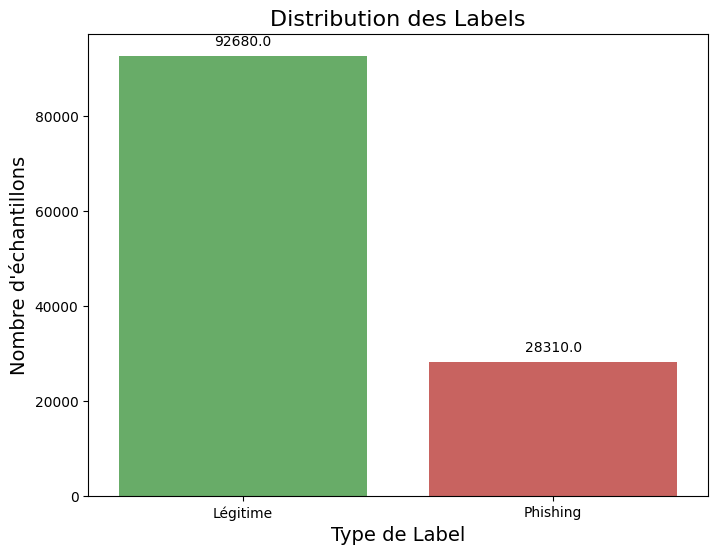

In [15]:
plot_label_distribution(preprocessed_data, 'label', title="Distribution des Labels")

The label distribution shows a marked imbalance between legitimate and phishing URLs. The green bar represents legitimate URLs with a sample count of 92,680, while the red bar represents phishing URLs with a sample count of 28,310. This indicates that the majority of URLs in the dataset are legitimate, and phishing URLs are significantly fewer in number.

Analysis of these results highlights a significant imbalance of classes in the dataset. This imbalance can potentially bias classification models, making them more inclined to predict that a URL is legitimate rather than phishing. This poses a particular challenge as phishing URLs, although fewer in number, are often the ones that require more accurate and rigorous detection.

To deal with this imbalance, I'm going to use the class rebalancing technique, SMOTE (Synthetic Minority Over-sampling Technique), which generates synthetic samples for the minority class, in this case, phishing URLs.

Translated with DeepL.com (free version)

In [16]:
def plot_wordcloud(text, mask=None, max_words=400, max_font_size=120, figure_size=(24.0,16.0),
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'com','http'}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color='white',
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size,
                    random_state = 42,
                    mask = mask)
    wordcloud.generate(text)

    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'green',
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()

In [17]:
df_Bad = preprocessed_data[preprocessed_data['label']==1.0].sample(frac=0.1, replace=True, random_state=1)
df_Good = preprocessed_data[preprocessed_data['label']==0.0].sample(frac=0.1, replace=True, random_state=1)

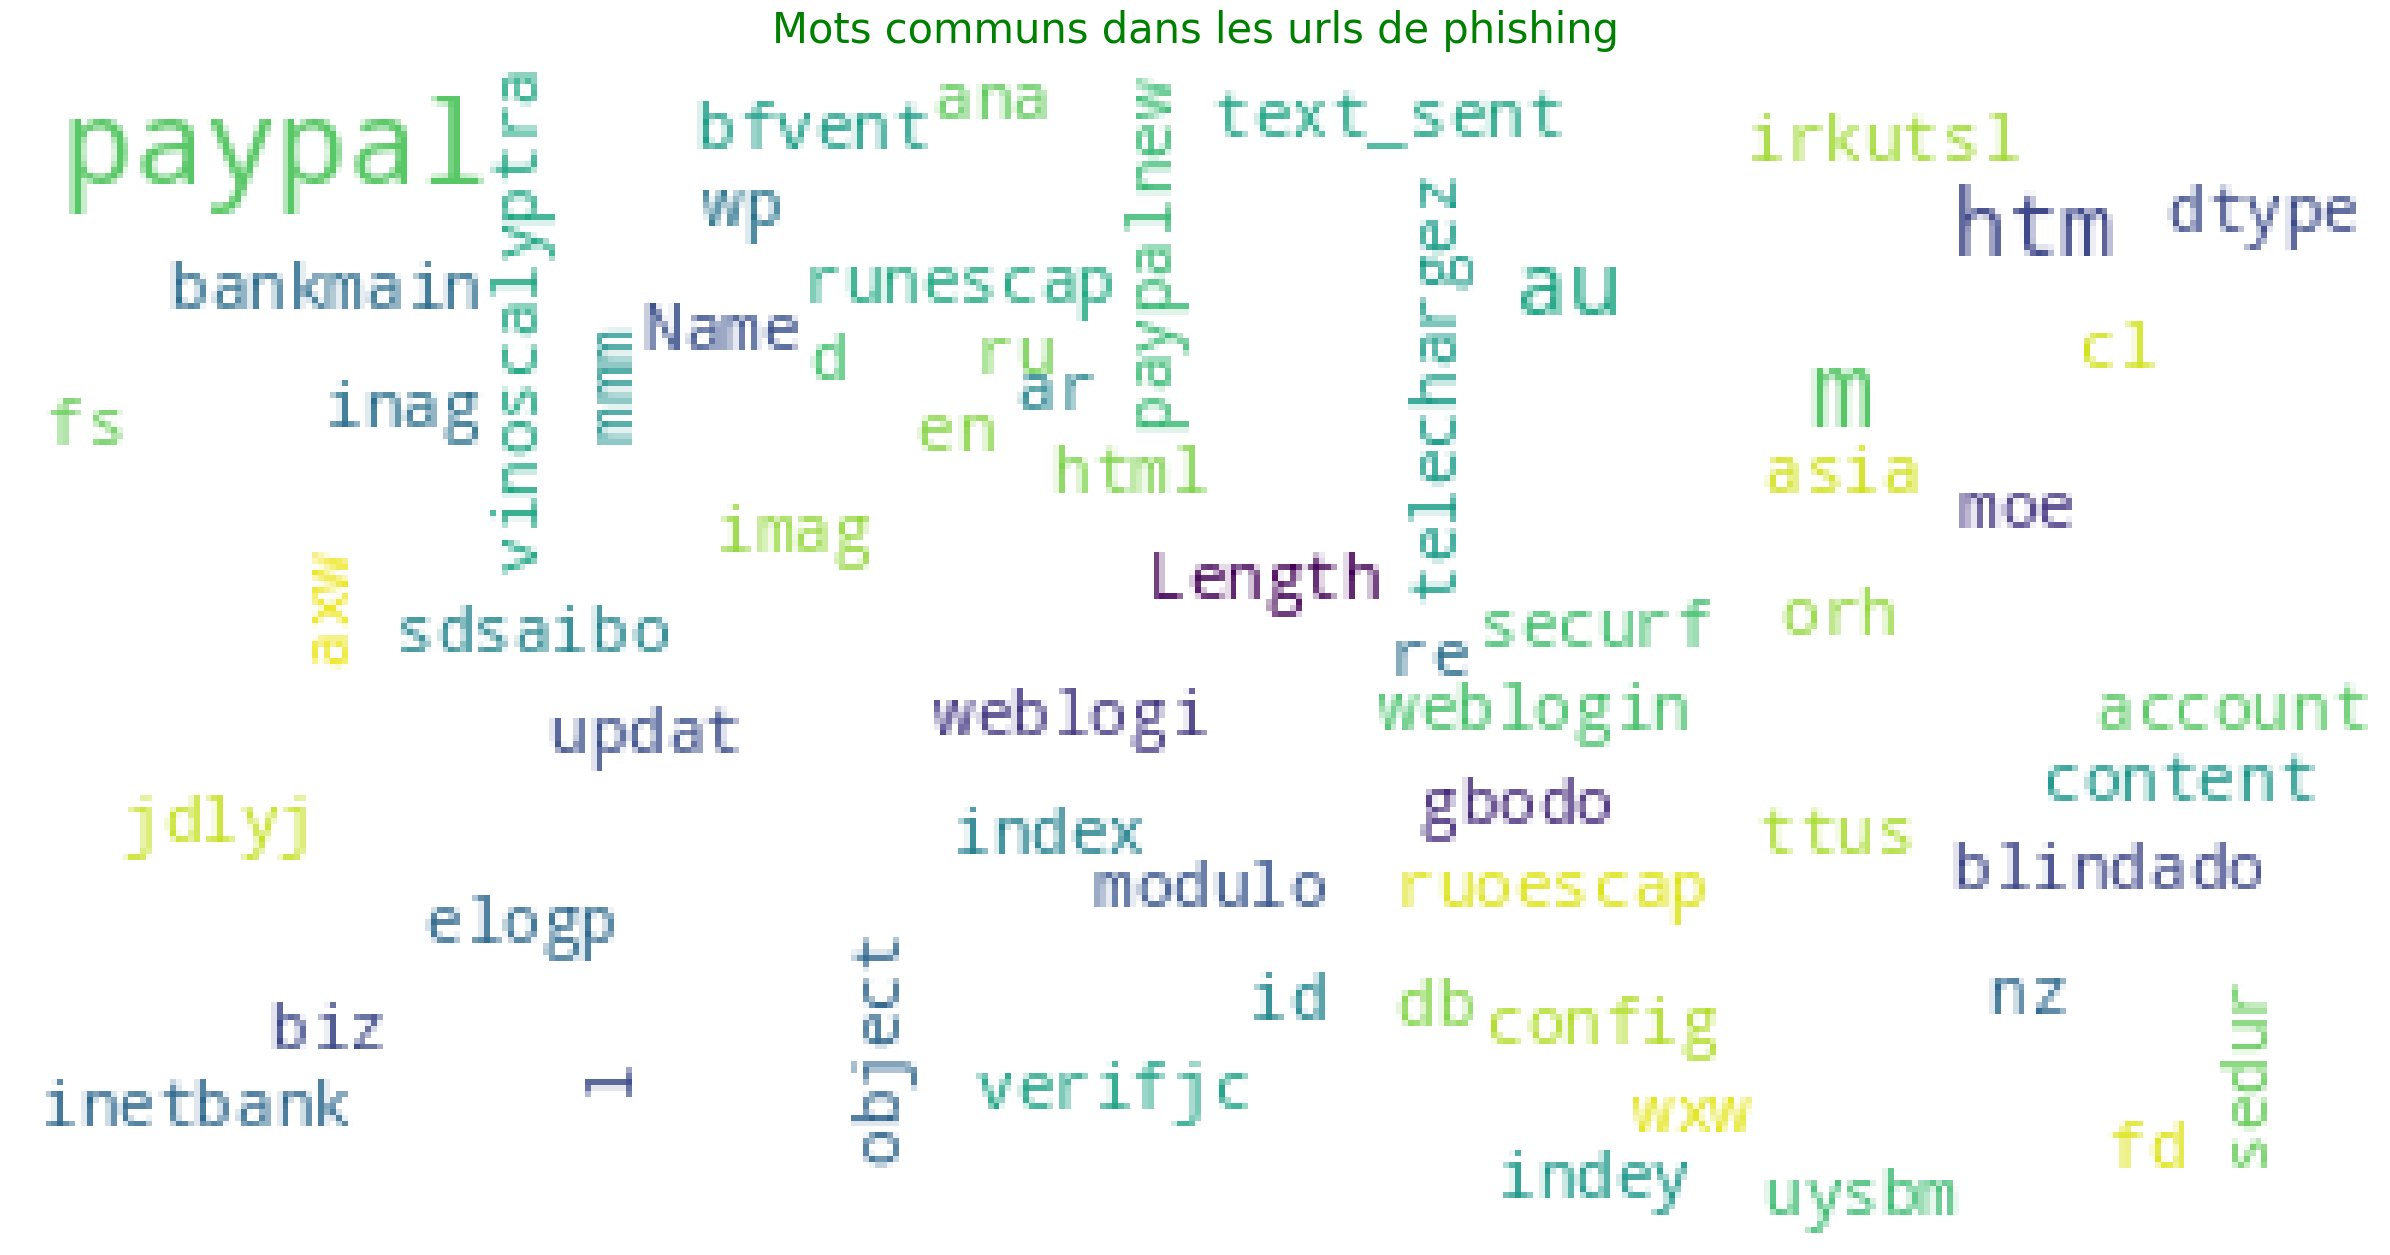

In [18]:
txt = str(df_Bad.text_sent)
plot_wordcloud(txt, max_words=500, max_font_size=20,
               title = 'Mots communs dans les urls de phishing', title_size=30)

The word cloud above shows that phishers use a variety of terms to make their URLs attractive and credible. Financial services and payment platforms such as PayPal are frequent targets. The use of domains from different countries and technical terms adds a layer of complexity, making the detection of phishing URLs more difficult.

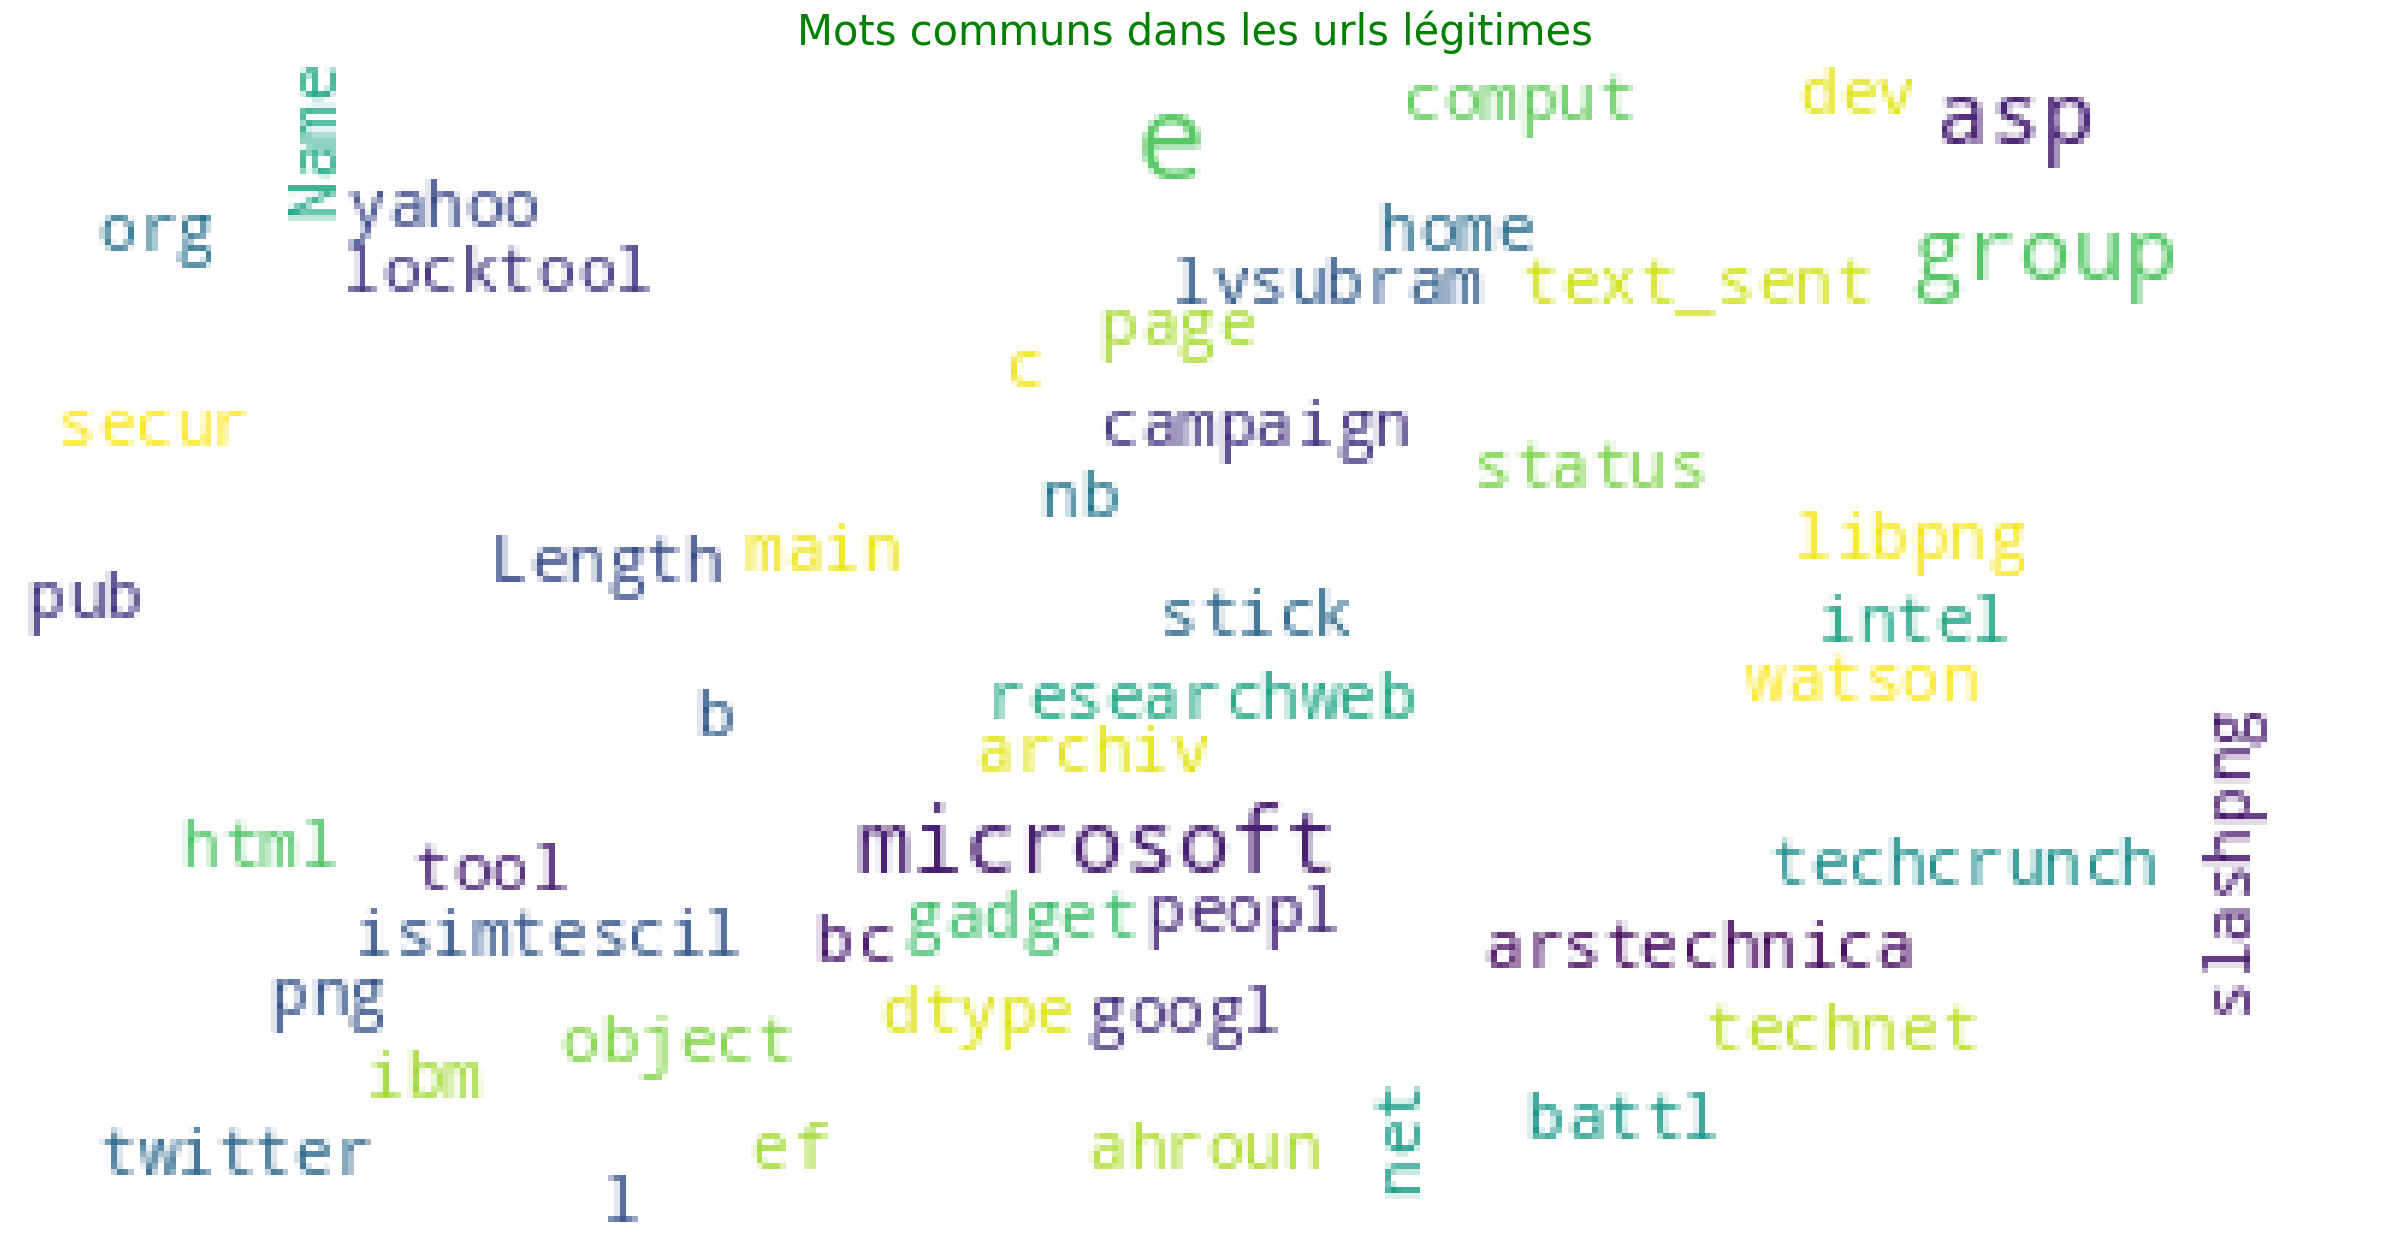

In [19]:
txt = str(df_Good.text_sent)
plot_wordcloud(txt, max_words=500, max_font_size=20,
               title = 'Mots communs dans les urls légitimes', title_size=30)

This word cloud shows that legitimate URLs are often associated with large, well-known technology companies, technical terms related to web development and references to technology news sites. Unlike phishing URLs, which often use generic and misleading terms, legitimate URLs tend to be more specific and reflect established brands and services.

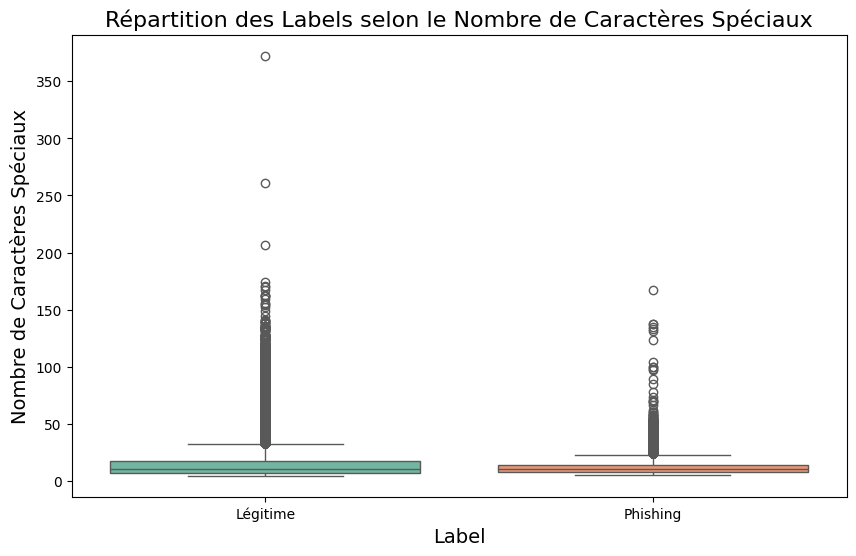

In [20]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='label_renamed', y='num_special_chars', data=preprocessed_data, palette='Set2')
plt.title('Répartition des Labels selon le Nombre de Caractères Spéciaux', fontsize=16)
plt.xlabel('Label', fontsize=14)
plt.ylabel('Nombre de Caractères Spéciaux', fontsize=14)
plt.show()

The number of special characters in a URL can be an intriguing indicator, though it is not sufficient on its own to reliably distinguish between legitimate and phishing URLs. Legitimate URLs tend to exhibit greater variability and a more frequent use of special characters, whereas phishing URLs are typically more uniform and employ fewer special characters.

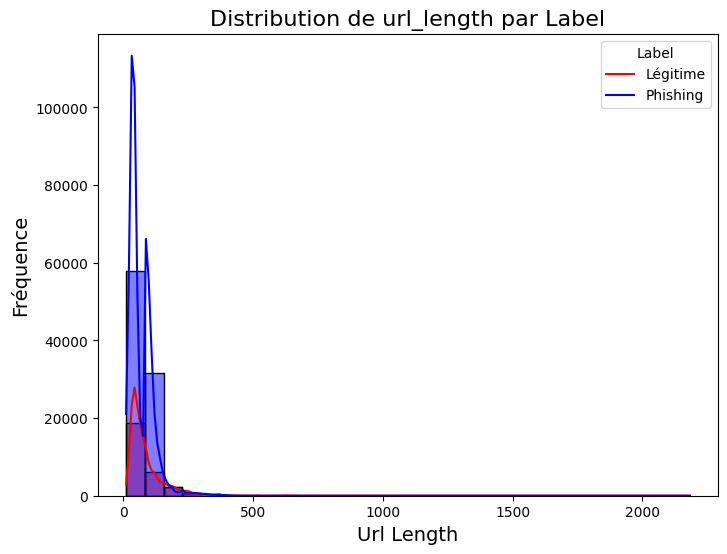

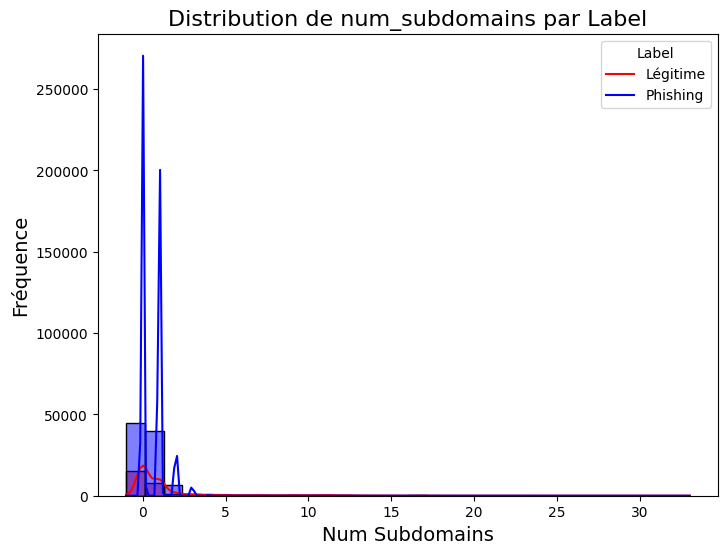

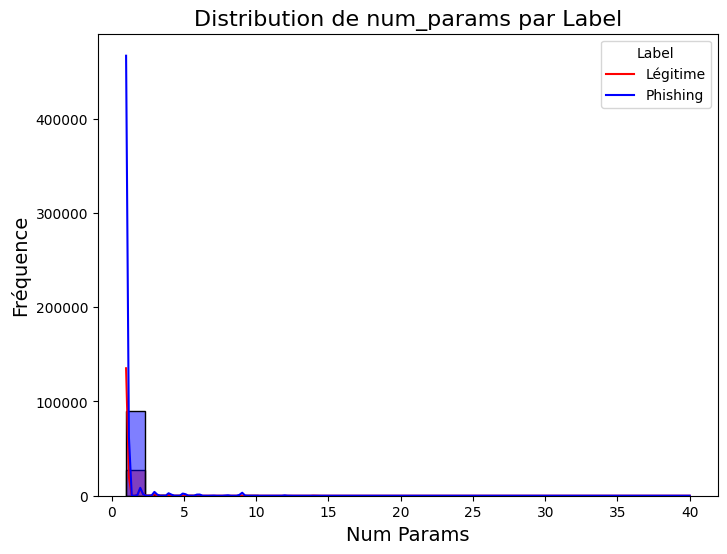

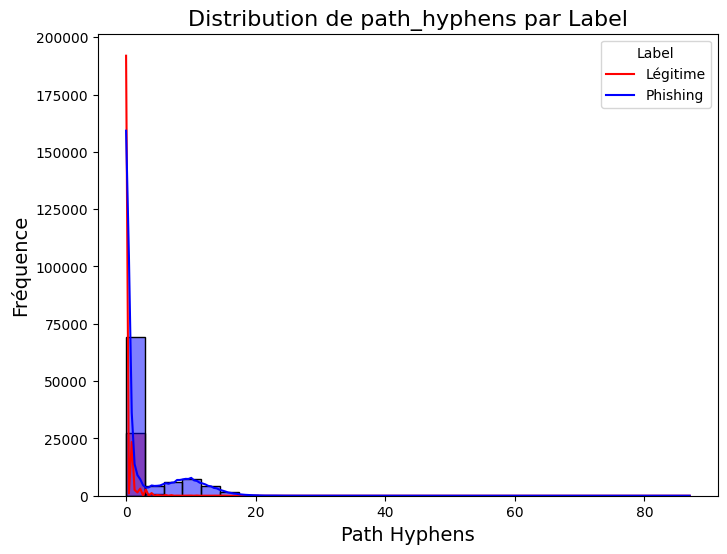

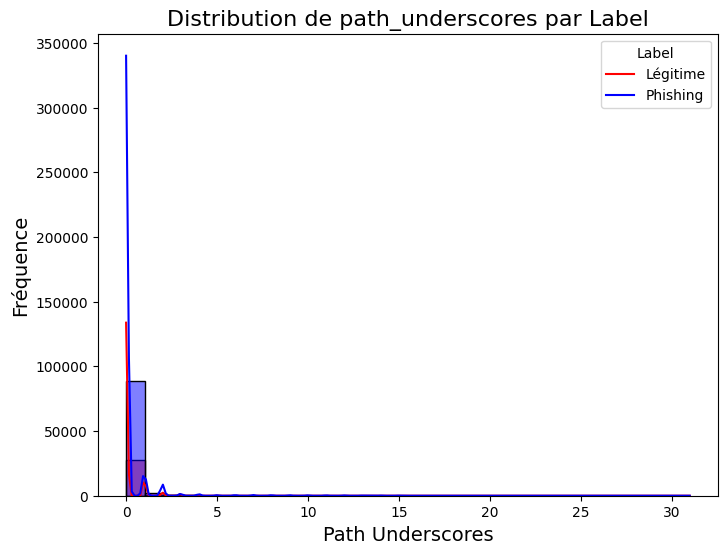

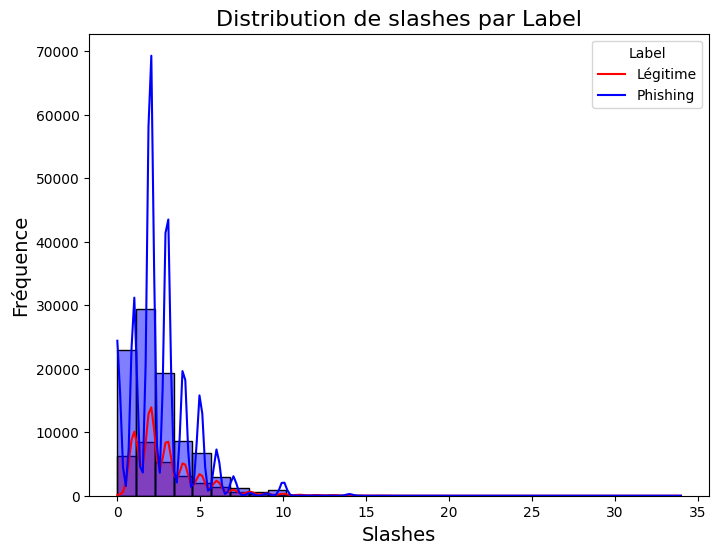

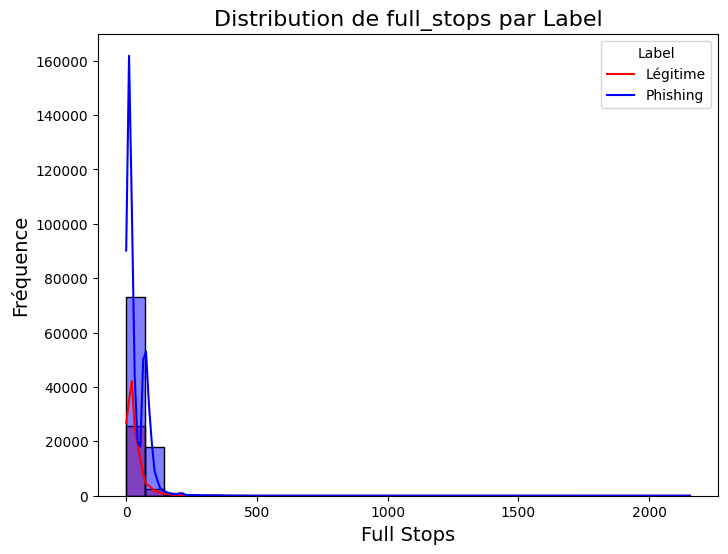

In [21]:
# Assurez-vous que les labels sont bien nommés
preprocessed_data['label_renamed'] = preprocessed_data['label'].apply(lambda x: 'Légitime' if x == 0.0 else 'Phishing')

# Liste des colonnes à tracer
columns_to_plot = ['url_length', 'num_subdomains', 'num_params', 'path_hyphens', 'path_underscores', 'slashes', 'full_stops']

for column in columns_to_plot:
    plt.figure(figsize=(8, 6))
    sns.histplot(data=preprocessed_data, x=column, hue='label_renamed', bins=30, kde=True, palette={'Légitime': 'blue', 'Phishing': 'red'})
    plt.title(f'Distribution de {column} par Label', fontsize=16)
    plt.xlabel(column.replace('_', ' ').title(), fontsize=14)
    plt.ylabel('Fréquence', fontsize=14)

    # Ajouter une légende
    plt.legend(title='Label', labels=['Légitime', 'Phishing'])

    plt.show()

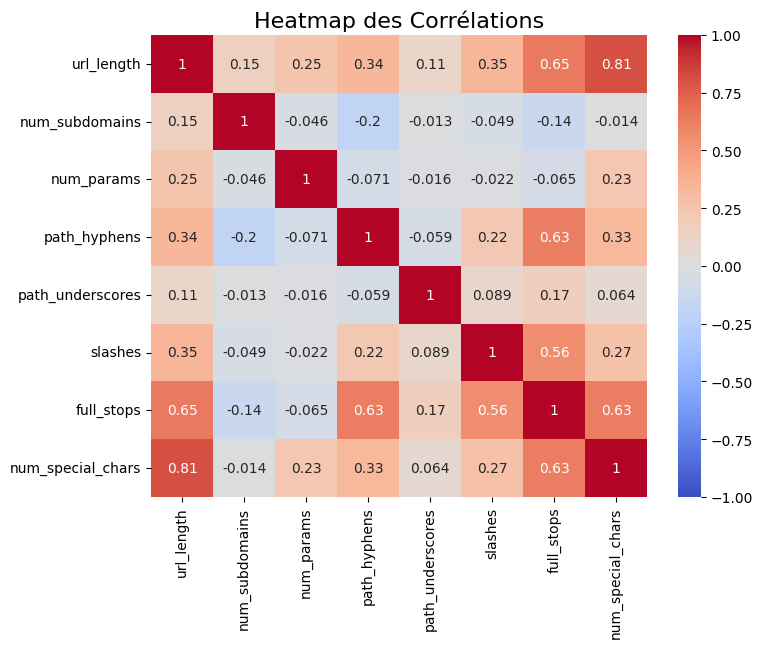

In [22]:
plt.figure(figsize=(8, 6))
corr = preprocessed_data[['url_length',
       'num_subdomains', 'num_params', 'path_hyphens', 'path_underscores',
       'slashes', 'full_stops', 'num_special_chars']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Heatmap des Corrélations', fontsize=16)
plt.show()


Considering the heatmap above, features with high correlations may be redundant and can potentially be reduced or combined to simplify the models. The weak negative correlations between certain characteristics suggest that they may provide distinct and useful information for classification. Therefore, it is crucial to consider these correlations when selecting features for classification models to enhance their performance and avoid duplication.

Based on this analysis, I have selected the features url_length, num_special_chars, num_subdomains, num_params, slashes, path_hyphens, and full_stops. This selection aims to improve model performance by capturing diverse and non-redundant aspects of URLs. This approach optimizes the use of data for classification, thereby enhancing the accuracy and robustness of the final stacking model.

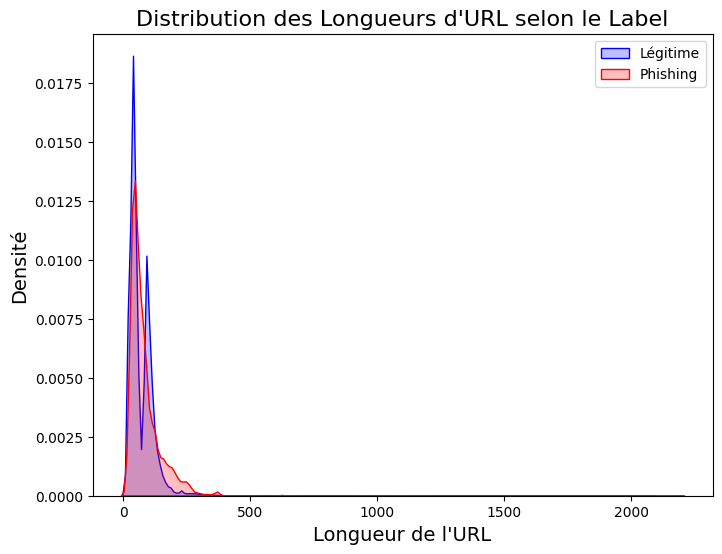

In [23]:
plt.figure(figsize=(8, 6))
sns.kdeplot(preprocessed_data[preprocessed_data['label'] == 0.0]['url_length'], shade=True, color='blue', label='Légitime')
sns.kdeplot(preprocessed_data[preprocessed_data['label'] == 1.0]['url_length'], shade=True, color='red', label='Phishing')
plt.title('Distribution des Longueurs d\'URL selon le Label', fontsize=16)
plt.xlabel('Longueur de l\'URL', fontsize=14)
plt.ylabel('Densité', fontsize=14)
plt.legend()
plt.show()

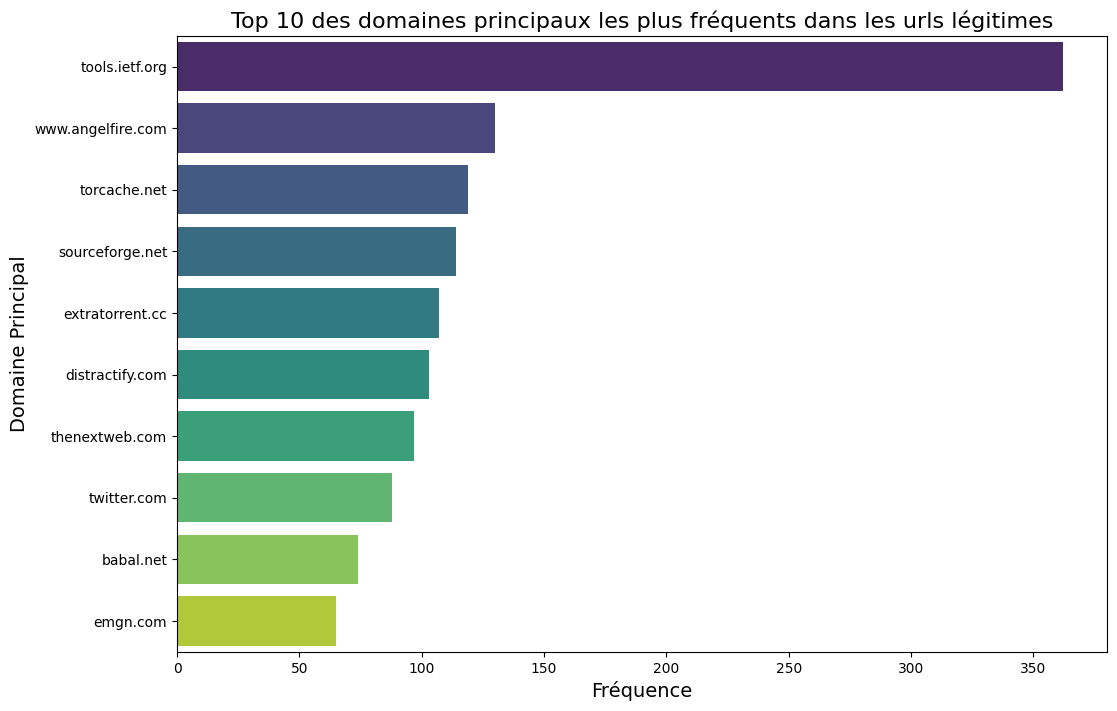

In [24]:
plt.figure(figsize=(12, 8))
top_domains = df_Good['domain_main'].value_counts().nlargest(10).index
sns.countplot(y='domain_main', data=df_Good[df_Good['domain_main'].isin(top_domains)], order=top_domains, palette='viridis')
plt.title('Top 10 des domaines principaux les plus fréquents dans les urls légitimes', fontsize=16)
plt.xlabel('Fréquence', fontsize=14)
plt.ylabel('Domaine Principal', fontsize=14)
plt.show()

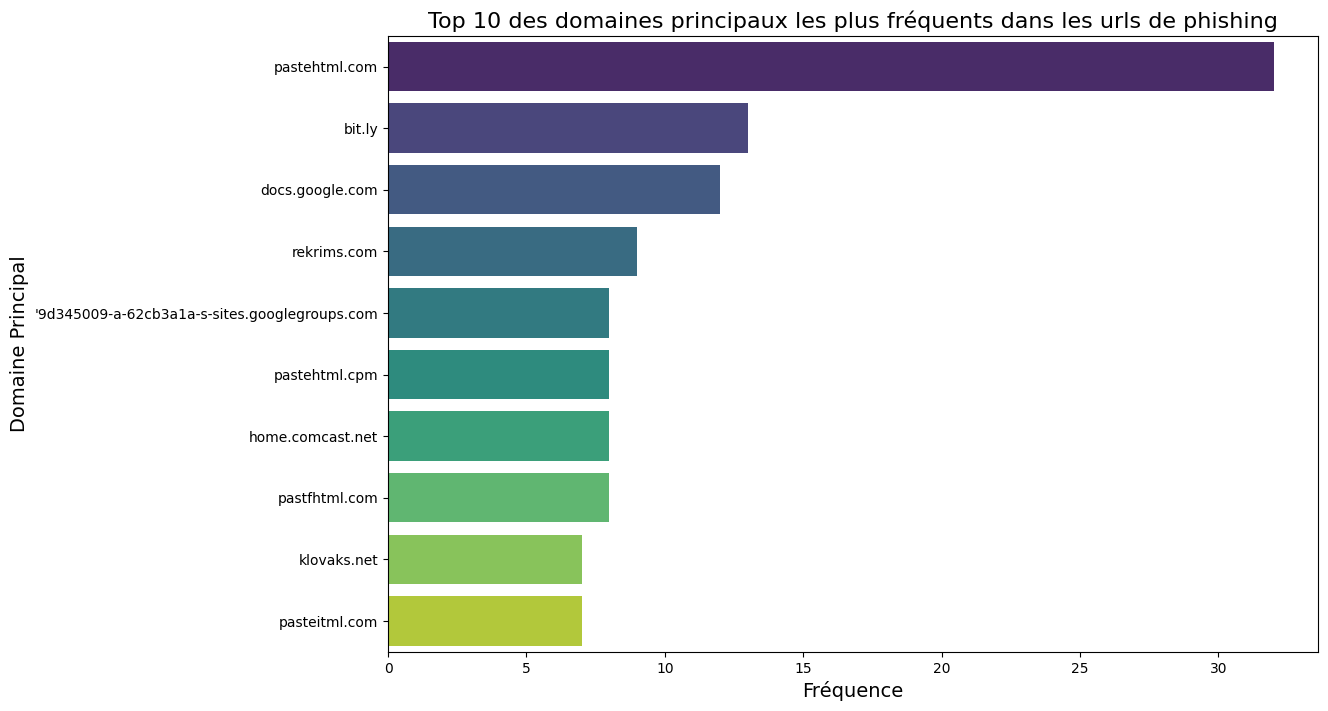

In [25]:
plt.figure(figsize=(12, 8))
top_domains = df_Bad['domain_main'].value_counts().nlargest(10).index
sns.countplot(y='domain_main', data=df_Bad[df_Bad['domain_main'].isin(top_domains)], order=top_domains, palette='viridis')
plt.title('Top 10 des domaines principaux les plus fréquents dans les urls de phishing', fontsize=16)
plt.xlabel('Fréquence', fontsize=14)
plt.ylabel('Domaine Principal', fontsize=14)
plt.show()

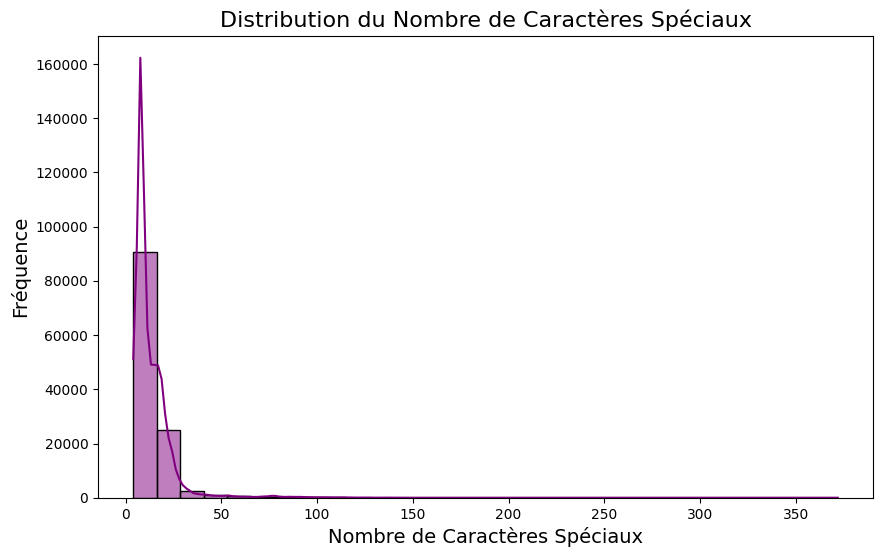

In [26]:
plt.figure(figsize=(10, 6))
sns.histplot(preprocessed_data['num_special_chars'], bins=30, kde=True, color='purple')
plt.title('Distribution du Nombre de Caractères Spéciaux', fontsize=16)
plt.xlabel('Nombre de Caractères Spéciaux', fontsize=14)
plt.ylabel('Fréquence', fontsize=14)
plt.show()

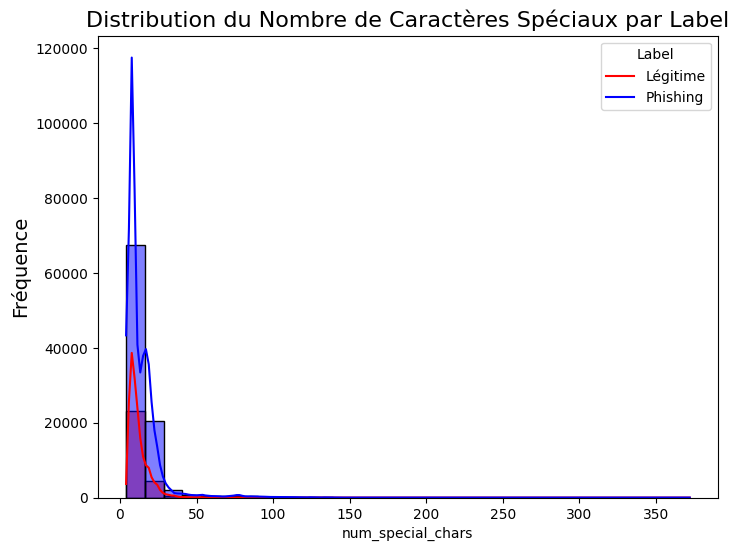

In [27]:
# Assurez-vous que les labels sont bien nommés
preprocessed_data['label_renamed'] = preprocessed_data['label'].apply(lambda x: 'Légitime' if x == 0.0 else 'Phishing')

plt.figure(figsize=(8,6 ))
sns.histplot(data=preprocessed_data, x='num_special_chars', hue='label_renamed', bins=30, kde=True, palette={'Légitime': 'blue', 'Phishing': 'red'})
plt.title('Distribution du Nombre de Caractères Spéciaux par Label', fontsize=16)
plt.ylabel('Nombre de Caractères Spéciaux', fontsize=14)
plt.ylabel('Fréquence', fontsize=14)

# Ajouter une légende
plt.legend(title='Label', labels=['Légitime', 'Phishing'])

plt.show()